## TOC:
* [Import Packages](#first-bullet)
* [EDA](#second-bullet)

## Import Packages <a class="anchor" id="first-bullet"></a>

In [3]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
#import xgboost as xgb

from sklearn.metrics import confusion_matrix , accuracy_score , precision_score , recall_score , f1_score , precision_recall_fscore_support , precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score , roc_auc_score , roc_curve
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)
figfont_size = 18 
titlefont_size = 18 
labelfont_size = 16 
ticksize = 14

In [5]:

def validation_metrics(X_train, y_train, X_test, y_test, fitted_pipeline):
    """    Print validation metrics including precision, recall, accuracy, confusion matrix.
    :param X_train: training predictors of loan level data
    :param y_train: training target of loan level data
    :param X_test: test predictors of loan level data
    :param y_test: test target of loan level data
    :param log_model: logistic regression
    :return: predicted result with col names ['prob', 'pred_label', 'actual_label']
    """
    # TODO: move this into another function
    # test data set prediction
    y_pred_prob = fitted_pipeline.predict_proba(X_test)[:, 1]
    y_pred = fitted_pipeline.predict(X_test)
    df_ll_prediction = pd.DataFrame(np.stack([y_pred_prob, y_pred, y_test], axis=1),
                                    columns=['prob', 'pred_label', 'actual_label'])

    # print the confusion matrix
    cnf_matrix = confusion_matrix(y_pred, y_test)
    print("""
     confusion matrix: y_actual vs y_pred
                 |     Actual
                 |   0   |   1
    ----------------------------
    Predict   0  |   a   |  b
              1  |   c   |  d  
    """
          )
    print(cnf_matrix)
    # plt.ylabel('Predicted label') #0-1 top to bottom
    # plt.xlabel('Actual label') # 0-1 left to right

    print("Accuracy of logistic regression classifier on train set: {:.2f}".
          format(fitted_pipeline.score(X_train, y_train)))
    print("Accuracy of logistic regression classifier on test set: {:.2f}".
          format(fitted_pipeline.score(X_test, y_test)))
    # print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision d/(c + d):", precision_score(y_test, y_pred))
    print("Recall d/(b + d):", recall_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))
    return df_ll_prediction


def AUC_curve(classifier ,X_test,  y_test, y_pred, y_score , title , path = '' , save = False) :
    fpr, tpr, _ = roc_curve(y_test,  y_score[:,1])
    auc = roc_auc_score(y_test , y_pred)
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(1,2,1)
    plt.plot([0,1],[0,1] , color='darkblue' , linestyle='--')
    plt.plot(fpr,tpr, color = 'orange',label=" auc="+str(auc))
    recall = recall_score(y_test,y_pred )
    precision =  precision_score(y_test,y_pred)
    f_score = f1_score(y_test,y_pred)
    textstr = '\n Recall = {:.2f} \n Percision = {:.2f} \n F1_score = {:.2f}'.format (recall ,precision , f_score )
    # textstr = '\n'.join((
    # r'$\Recall=%.2f$' % (recall, ),
    # r'$\mathrm{Percision}=%.2f$' % (precision, ),
    # r'$\F!_score=%.2f$' % (f_score, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    ax1.set_xlabel('False Positive')
    ax1.set_ylabel('True Positive')
    ax1.legend(loc=4)
    ax2 = fig.add_subplot(1,2,2)
    average_precision = average_precision_score(y_test, y_score[:,1])
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_score[:,1])
    plt.plot(lr_precision, lr_recall ,  label = 'Average Percision = {:.2f}'.format(average_precision))
    plt.scatter(precision , recall  , marker= 'o'  , c = 'k' , s = 100 )
   # plot_precision_recall_curve(classifier, X_test, y_test)
    # disp.ax_.set_title('2-class Precision-Recall curve: '
    #                 'AP={0:0.2f}'.format(average_precision))
    
    ax2.set_xlabel('Precision')
    ax2.set_ylabel('Recall')
    ax2.legend()
    
    fig.suptitle( title , fontweight = 'bold' , y=0.94, fontsize = figfont_size)
    if save :
        fig.savefig(path+title+'.png')
    plt.show()
    
    
    
def plot_importance (importance , n_features , feature_list , title ,  path = '' , save = False ) :
    #import pdb; pdb.set_trace()
    if importance.shape[0] != 1:
        importance = np.array(importance).reshape((1, len(importance)))
    # import pdb; pdb.set_trace()
    indices = importance.argsort()[0,:][::-1]
    fig = plt.figure(figsize=(12,8))
    plt.bar(range(n_features) , importance[0,indices[:n_features].tolist()])
    plt.xticks(range(n_features), feature_list[indices[:n_features]] , rotation='vertical')
    plt.xlabel('Feature' , fontsize = labelfont_size)
    plt.ylabel('Importance' ,  fontsize = labelfont_size)
    plt.tick_params(labelsize=ticksize, pad=6)
    #plt.table(cellText=np.array(pd.DataFrame(df_.columns[indices_tree[:20]] , index = indices_tree[:20])) , loc = 'bottom' , rowLabels = indices_tree[:20] , edges = 'open' )
    fig.suptitle( title , fontweight = 'bold' , y=0.94, fontsize = figfont_size)
    if save :
        fig.savefig(path+title+'.png')
    plt.show()
    
def plot_history(history , metric , title , path = '' , save = False) :
    history = clf.evals_result_
    x_axis = range(len(history['validation_0'][metric]))
    plt.plot(x_axis, history['validation_0'][metric], label = 'Train')
    plt.plot(x_axis, history['validation_1'][metric], label = 'Test')
    plt.legend(loc = 'best')
    plt.ylabel(metric)
    plt.title(title , fontsize = figfont_size )
    if save :
        fig.savefig(path+title+'.png')
    plt.show()
    
def f_1 (y_pred , y_true):
    y_true = xgb.DMatrix(y_true)
   # y_true = dtrain.get_label()
    return 'f_1' , 1-f1_score(y_true, y_pred, average='macro')


def misclassified(y_pred, y_true):
    """
    custom evaluation metric for xgboost, the metric
    counts the number of misclassified examples assuming 
    that classes with p>0.5 are positive
    """
    labels = y_true.get_label() # obtain true labels
    preds = y_pred > 0.5 # obtain predicted values
    return 'misclassified', np.sum(labels != preds)



    

# Loading Dataset and preprocessing 

In [21]:
df = pd.read_pickle('data_Michigan.pkl')  # it is in data_state


In [29]:
df.shape

(2665135, 75)

In [6]:
#df.dropna(axis = 'index' , inplace = True )      
df = pd.read_pickle('data_state_3/data_Michigan.pkl')  # it is in data_state

cat_variable =  ['quarter' , 'income_categorical' ,'#OFCars_categorical' , 'income_census_categorical' ]
num_variable = ['CarAge'  ,   'Q_1', 'Q_2', 'Q_3', 'Q_4','p_16', 'p_15', 'p_14',
       'p_13', 'p_12', 'p_11', 'p_10', 'p_9', 'p_8', 'p_7', 'p_6', 'p_5',
       'p_4', 'p_3', 'p_2', 'p_1' , 'total_car_census' , 'OldestAge',
       'AveCar'  ] 

onehot_variable =  ['BoyAgeBw0And2', 'GirlAgeBw0And2',
       'UnknownAgeBw0And2', 'BoyAgeBw3And5', 'GirlAgeBw3And5',
       'UnknownAgeBw3And5', 'BoyAgeBw6And10', 'GirlAgeBw6And10',
       'UnknownAgeBw6And10', 'BoyAgeBw11And15', 'GirlAgeBw11And15',
       'UnknownAgeBw11And15', 'BoyAgeBw16And17', 'GirlAgeBw16And17',
       'UnknownAgeBw16And17', 'MalesAgeBw18And24', 'FemalesAgeBw18And24',
       'UnknownAgeBw18And24', 'MalesAgeBw25And34', 'FemalesAgeBw25And34',
       'UnknownAgeBw25And34', 'MalesAgeBw35And44', 'FemalesAgeBw35And44',
       'UnknownAgeBw35And44', 'MalesAgeBw45And54', 'FemalesAgeBw45And54',
       'UnknownAgeBw45And54', 'MalesAgeBw55And64', 'FemalesAgeBw55And64',
       'UnknownAgeBw55And64', 'MalesAgeBw65And74', 'FemalesAgeBw65And74',
       'UnknownAgeBw65And74', 'MalesAge75Plus', 'FemalesAge75Plus',
       'UnknownAge75Plus']

feature_drop = ['ID' , 'date' , 'income' , 'censusId', 'year' , 'cen_income' , '#OfCars' , 'SumAge' , 'ZipCode' , 'State' , 'cen_income']
          



# Dropping no_car 
#df = pd.read_pickle('data_state_3/data_Michigan.pkl')  # it is in data_state
df= df[~(df['#OFCars_categorical']=='No_car')].copy(True) # Dropping the 'no-car level from the data '

df_drop = df[feature_drop]
y = df['label'].astype('int')
df.drop('label' , axis = 1 , inplace = True) # df.shape = (2259585, 73)
df.drop(feature_drop , axis = 1 , inplace = True) # (2259585, 64)


assert  'label' not in df.columns , 'label is still in the feature space'    

In [7]:
df_cat = pd.get_dummies(df[cat_variable]) 
df_cat.reset_index(drop = True , inplace = True)
df_num = pd.DataFrame(StandardScaler().fit_transform(df[num_variable]), columns = num_variable)
df_num.reset_index(drop = True , inplace = True)
df_one = df[onehot_variable].astype('int')
df_one.reset_index(drop = True , inplace = True)
df_final= pd.concat([df_cat, df_num , df_one ],  axis = 1 )
#df_final.index = df_drop['date']


if '#OFCars_categorical_No_car' in df_final.columns:
    df_final.drop('#OFCars_categorical_No_car' , axis = 1 , inplace = True)  

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_final,y,test_size=0.33, random_state=44) 

## EDA <a class="anchor" id="second-bullet"></a>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

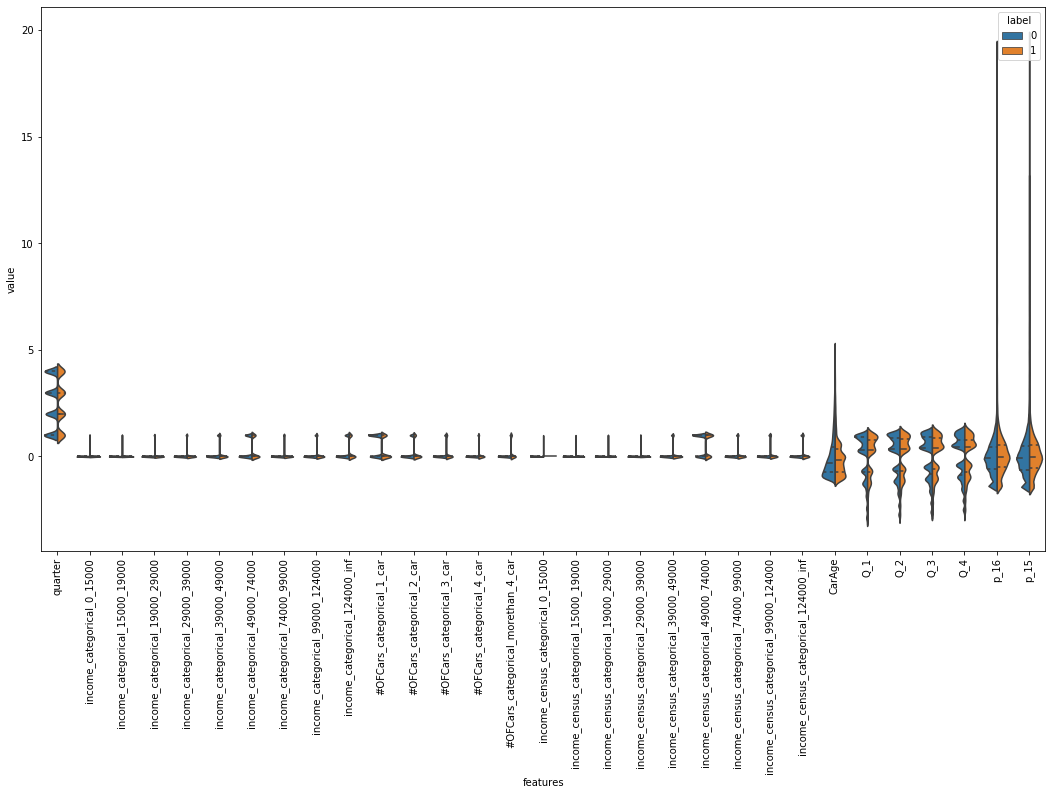

In [52]:
data_dia = y
data = df_final
#data_n_2 = (data - data.mean()) / (data.std()) # standardization
data = pd.concat([y.reset_index(drop= True),data.iloc[:,0:31].reset_index(drop= True)],axis=1) # first 10 features
data = pd.melt(data,id_vars="label",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(18,10))
sns.violinplot(x="features", y="value", hue="label", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

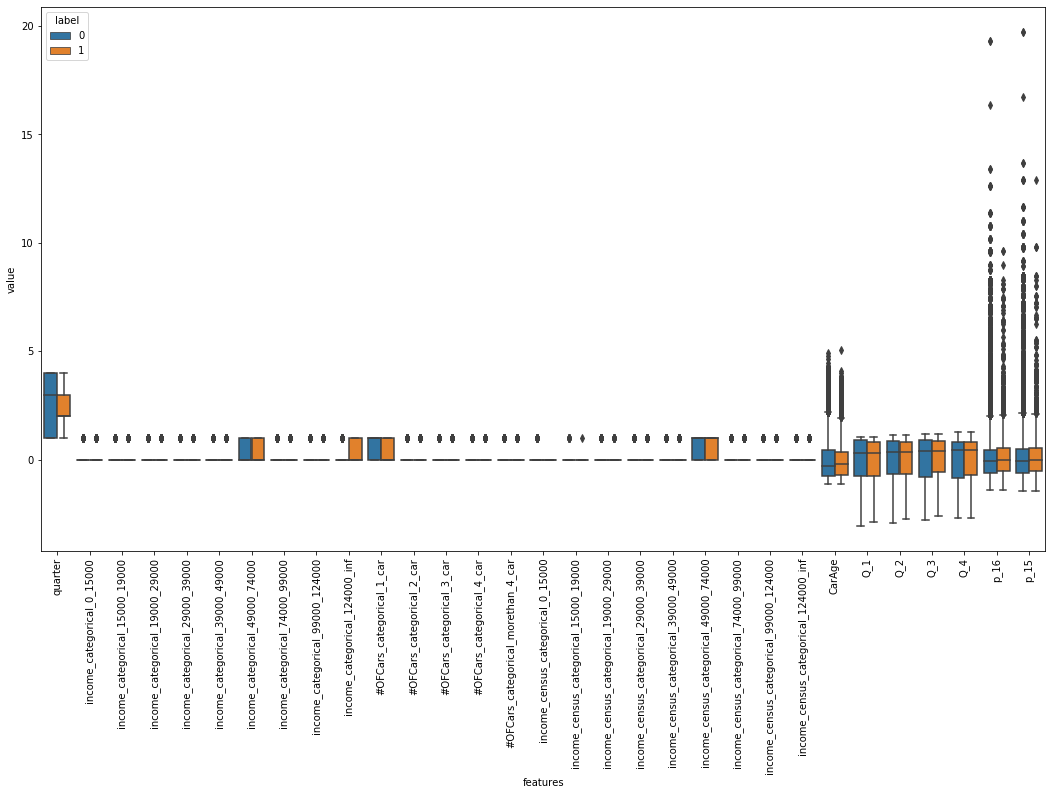

In [53]:
plt.figure(figsize=(18,10))
sns.boxplot(x="features", y="value", hue="label", data=data)
plt.xticks(rotation=90)

In [ ]:
sns.set(style="whitegrid", palette="muted")
plt.figure(figsize=(18,10))
sns.swarmplot(x="features", y="value", hue="label", data=data)
plt.xticks(rotation=90)

# Random Forest & XGBoost Hyper tuning 

1. Using Hyperopt package, Random Forest hyper tuning was run for 400 evaluations and XGBoost for 100 evaluations.
2. Add hyper params for each !!!!
3. metrics = [Precision , Recall , F-1 , Support , Accuracy]
4. Loss = 1 - f1

# XGBOOST Training and Results

In [92]:
#df = pd.read_pickle('data_state_3/data_Michigan.pkl')
xgb_tune = pd.read_pickle('./XGB_vm/df_tune.pkl')

In [93]:
xgb_tune.head()

,loss,train_metric,test_metric,params
0,0.909983,"(1.0, 1.0, 1.0, None, 1.0)","(0.5479272181579441, 0.04903639538006983, 0.09001679532812522, None, 0.9299782193455369)","{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7000000000000002, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.25, 'max_delta_step': 0, 'max_depth': 93, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 93, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.883655493080739, 'tree_method': None, 'validate_parameters': False, 'verbosity': None, 'class_weight': 37, 'sample_weight': [1, 1, 1, 1, 1, 1, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 37, 1, 37, 1, 37, 37, 1, 1, 1, 1, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 37, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 37, 1, 1, 1, 1, 1, 1, 1, 1, ...]}"
1,0.938963,"(0.9997316836848774, 0.5548137853443854, 0.713603983677986, None, 0.968562376815826)","(0.7795632468067573, 0.031762019876443726, 0.06103718041777562, None, 0.9309812914019177)","{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7000000000000002, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 35, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 60, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8357507502101729, 'tree_method': None, 'validate_parameters': False, 'verbosity': None, 'class_weight': 82, 'sample_weight': [1, 1, 1, 1, 1, 1, 82, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 82, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 82, 1, 82, 1, 82, 82, 1, 1, 1, 1, 82, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 82, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 82, 1, 1, 1, 1, 1, 1, 1, 1, ...]}"
2,0.917629,"(1.0, 1.0, 1.0, None, 1.0)","(0.6067312125403411, 0.044184797206553855, 0.08237098238037116, None, 0.9304702700587734)","{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6000000000000001, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.2, 'max_delta_step': 0, 'max_depth': 98, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 79, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9078719101700635, 'tree_method': None, 'validate_parameters': False, 'verbosity': None, 'class_weight': 94, 'sample_weight': [1, 1, 1, 1, 1, 1, 94, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 94, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 94, 1, 94, 1, 94, 94, 1, 1, 1, 1, 94, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 94, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 94, 1, 1, 1, 1, 1, 1, 1, 1, ...]}"
3,0.922403,"(0.9999917268538052, 0.999917274697639, 0.9999544993898782, None, 0.9999935761734433)","(0.645237470480189, 0.0412805533172173, 0.07759668028842362, None, 0.9306848753096066)","{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.5, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': None, 'learning_rate': 0.15000000000000002, 'max_delta_step': 0, 'max_depth': 38, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 96, 'n_jobs': -1, 'num_parallel_tree': 1, 'ra

In [94]:
xgb_best_index = np.argmax(-xgb_tune['loss'])

In [95]:
xgb_best_index

28

In [96]:
params = xgb_tune['params'][xgb_best_index]

In [97]:
params

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7000000000000002,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.25,
 'max_delta_step': 0,
 'max_depth': 93,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 92,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.9632681873604783,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'class_weight': 79,
 'sample_weight': array([1, 1, 1, ..., 1, 1, 1], dtype=int32)}

In [98]:
del params['booster'] , params['gpu_id'] , params['interaction_constraints'] , params['missing'] , params['monotone_constraints'] , params['tree_method'] ,  params['verbosity'] , params['sample_weight']

In [99]:
clf = xgb.XGBClassifier(**params)
sample_weight = np.where(y_train ==1 , params['class_weight'] , 1)
clf.set_params(sample_weight = sample_weight)
eval_set = [(X_train, y_train) , (X_test, y_test)]

In [100]:
clf.fit(X_train , y_train , eval_set=eval_set , eval_metric= 'auc'  , verbose=True , early_stopping_rounds= 10 )

[0]	validation_0-auc:0.734793	validation_1-auc:0.654227
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.783241	validation_1-auc:0.659701
[2]	validation_0-auc:0.841076	validation_1-auc:0.658775
[3]	validation_0-auc:0.89786	validation_1-auc:0.64577
[4]	validation_0-auc:0.93838	validation_1-auc:0.638914
[5]	validation_0-auc:0.967903	validation_1-auc:0.634383
[6]	validation_0-auc:0.981709	validation_1-auc:0.632042
[7]	validation_0-auc:0.989553	validation_1-auc:0.633173
[8]	validation_0-auc:0.994398	validation_1-auc:0.634222
[9]	validation_0-auc:0.99666	validation_1-auc:0.633641
[10]	validation_0-auc:0.998114	validation_1-auc:0.63673
[11]	validation_0-auc:0.998881	validation_1-auc:0.635435
Stopping. Best iteration:
[1]	validation_0-auc:0.783241	validation_1-auc:0.659701



XGBClassifier(base_score=0.5, booster='gbtree', class_weight=79,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7000000000000002, gamma=0, learning_rate=0.25,
              max_delta_step=0, max_depth=93, min_child_weight=1, missing=None,
              n_estimators=92, n_jobs=-1, nthread=None, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, sample_weight=array([ 1,  1, 79, ...,  1,  1,  1]),
              scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9632681873604783, validate_parameters=False,
              verbosity=1)

In [101]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

In [102]:
Y = pd.DataFrame({'True' : y_test , 'score' : y_score[:,1] , 'pred' : y_pred})
Y['Cat'] = pd.cut(Y['score'], right = False , bins=[0, .3 , .4 , .5 , .6 , 1] )
report = Y.groupby('Cat')['True'].agg( ['count', 'sum'])
report['Posratio'] = report['sum']/report['count']
report['NegRatio'] = (report['count'] -  report['sum'])/report['count']
report.rename(columns={'count':'Observation Count' ,'sum':'Purchases' } , inplace = True)
report.fillna(0 , inplace= True)

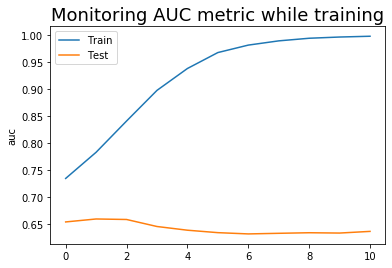

In [103]:
plot_history(history = clf.evals_result_ , metric = 'auc' , title = 'Monitoring AUC metric while training' , path = '' , save = False)

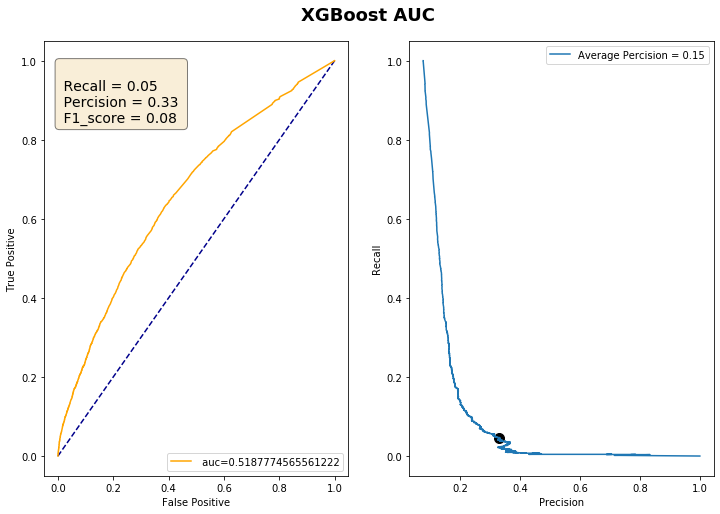

In [104]:
AUC_curve(clf ,X_test,  y_test, y_pred, y_score , title = 'XGBoost AUC' , path = '')

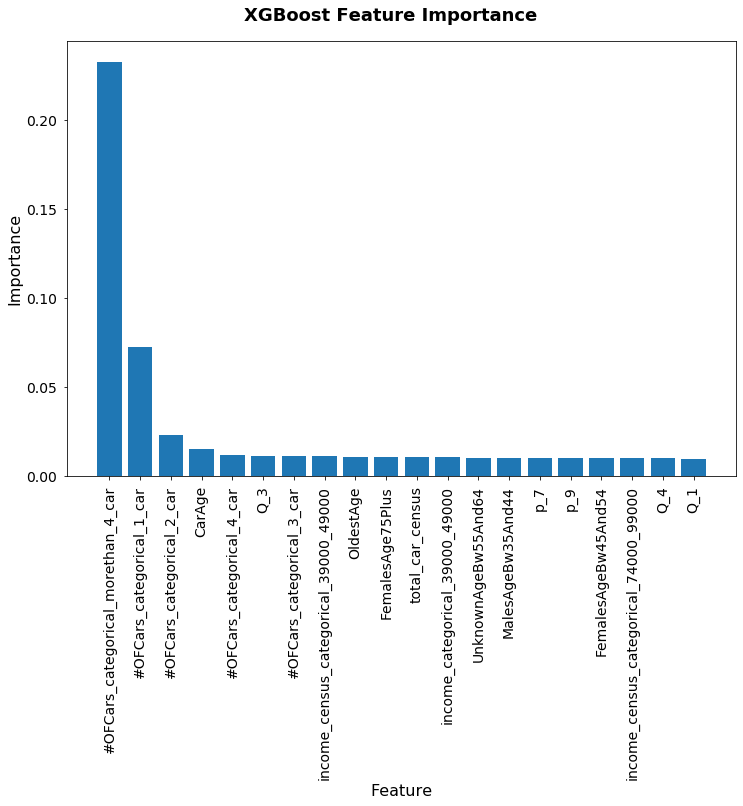

In [105]:
plot_importance (clf.feature_importances_ , n_features = 20  , feature_list = X_train.columns , title = 'XGBoost Feature Importance' ,  path = '' )

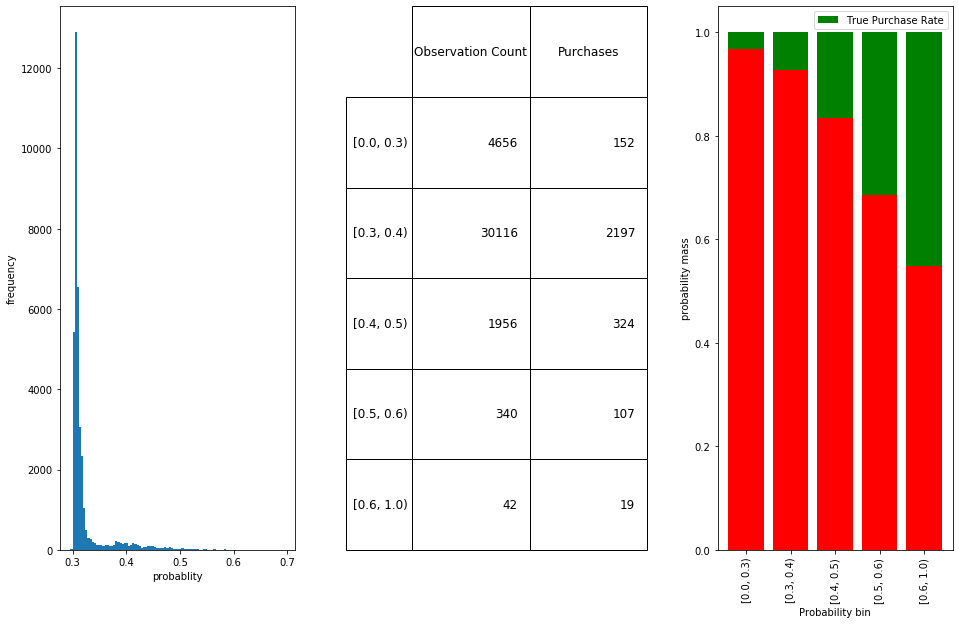

In [106]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(1,3,1)
plt.hist(y_score[:,1] , bins = 100) ;
ax1.set_xlabel('probablity')
ax1.set_ylabel('frequency')
ax2 = fig.add_subplot(1,3,2)
#box = Bbox.from_bounds(0, 0 , 10, 10)
table = plt.table(cellText=report.iloc[:,:2].values , rowLabels= report.index, colLabels=report.columns ,bbox = [0.1, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2,2)

ax2.axis('off')
ax3 = fig.add_subplot(1,3,3)
ind = np.arange(5)
bar2 = ax3.bar([0,1,2,3,4], report['NegRatio']  , color = 'r')
bar1 = ax3.bar([0,1,2,3,4], report['Posratio'] , bottom = report['NegRatio'] , label = 'True Purchase Rate' , color = 'g')
ax3.set_xlabel('Probability bin')
ax3.set_ylabel('probability mass')
plt.xticks(ind, report.index , rotation='vertical' );
plt.legend()
#ax2.hist([Y[Y['True']==0]['Cat'] , Y[Y['True']==1]['Cat']],
        #  rwidth=0.8 , color = ['g','r'] , label = ['+ve corr','-ve corr'] , align = 'mid')
plt.subplots_adjust(wspace= .4)
plt.show()


In [107]:
rf_tune = pd.read_pickle('./RF_vm/RF_tune.pkl')
rf_best_index = np.argmax(-rf_tune['loss'])
rf_params = rf_tune['params'][rf_best_index]

In [108]:
rf_tune.head()

,loss,train_metric,test_metric,params
0,0.854215,"(0.07826645723261459, 1.0, 0.14517090225265192, None, 0.1432648023041291)","(0.07876850411842636, 0.9771346909610575, 0.1457850270515178, None, 0.1363244408515225)","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 59}, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 62, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}"
1,0.797789,"(0.24980619271284601, 0.9994526546250684, 0.3997081357168916, None, 0.7816120940233333)","(0.12830370014416145, 0.4769560557341908, 0.2022114510754317, None, 0.7161412018323902)","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 41}, 'criterion': 'gini', 'max_depth': 19, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 99, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}"
2,0.976584,"(1.0, 0.9979930669585843, 0.9989955255227834, None, 0.9998540010352653)","(0.3238095238095238, 0.012147195426938193, 0.023415977961432504, None, 0.9235785502559957)","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 74}, 'criterion': 'gini', 'max_depth': 96, 'max_features': 0.25, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 87, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}"
3,0.965157,"(1.0, 0.18098887064404307, 0.30650393944075394, None, 0.9404191497551199)","(0.704225352112676, 0.01786352268667381, 0.03484320557491289, None, 0.9253570466181622)","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 17, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 72, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}"
4,0.955293,"(0.995092693565976, 0.9989053092501369, 0.9969953564599836, None, 0.9995620031057961)","(0.27983539094650206, 0.024294390853876385, 0.04470742932281394, None, 0.921692266235516)","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 68}, 'criterion': 'gini', 'max_depth': 60, 'max_features': 0.25, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 88, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}"


In [109]:
rf_best_index

94

In [110]:
rf_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 50},
 'criterion': 'gini',
 'max_depth': 21,
 'max_features': 0.25,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 60,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [111]:
RF = RandomForestClassifier(**rf_params )
RF.fit(X_train , y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 50}, criterion='gini',
                       max_depth=21, max_features=0.25, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [112]:
y_pred = RF.predict(X_test)
y_score = RF.predict_proba(X_test)

In [113]:
Y_RF = pd.DataFrame({'True' : y_test , 'score' : y_score[:,1] , 'pred' : y_pred})
Y_RF['Cat'] = pd.cut(Y_RF['score'], right = False , bins=[0, .3 , .4 , .5 , .6 , .8 , .9 , 1] )
report = Y_RF.groupby('Cat')['True'].agg( ['count', 'sum'])
report['Posratio'] = report['sum']/report['count']
report['NegRatio'] = (report['count'] -  report['sum'])/report['count']
report.rename(columns={'count':'Observation Count' ,'sum':'Purchases' } , inplace = True)
report.fillna(0 , inplace= True)

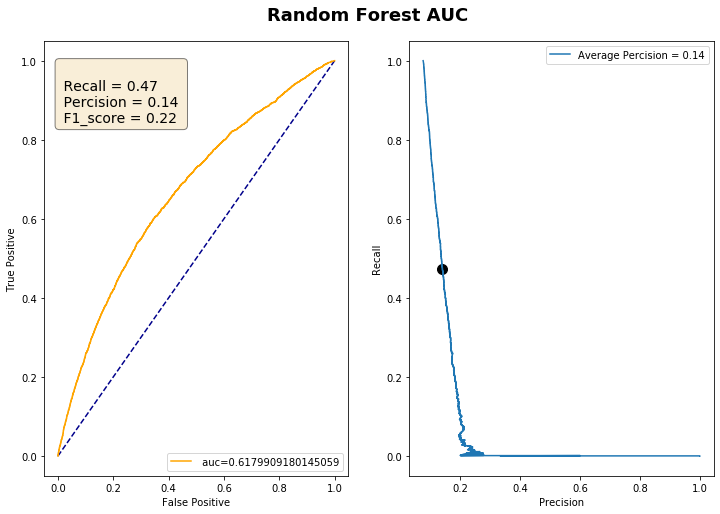

In [114]:
AUC_curve(RF ,X_test,  y_test, y_pred, y_score , title = 'Random Forest AUC' , path = '')

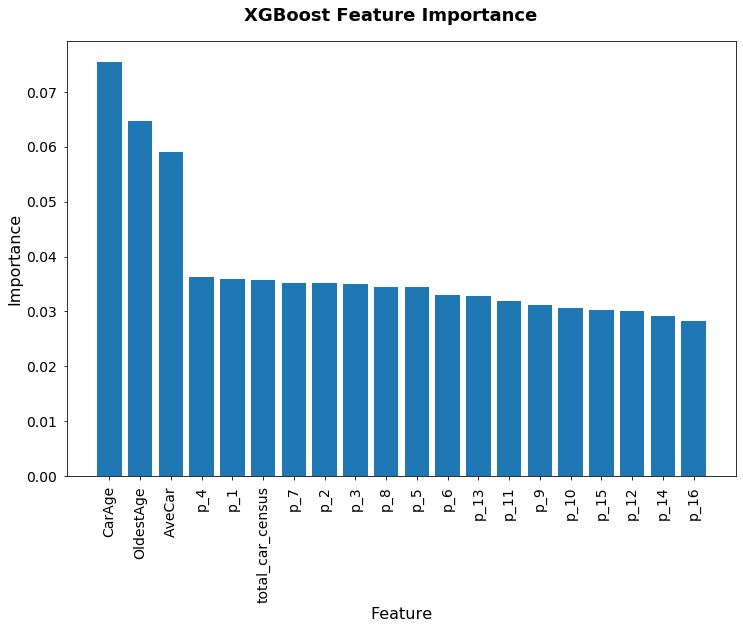

In [115]:
plot_importance (RF.feature_importances_ , n_features = 20  , feature_list = X_train.columns , title = 'XGBoost Feature Importance' ,  path = '' )

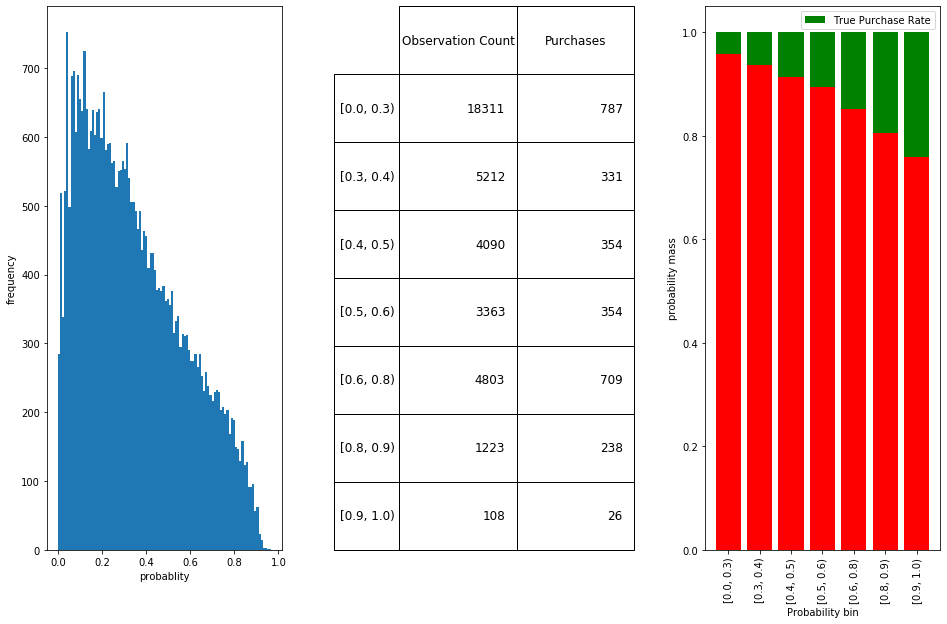

In [116]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(1,3,1)
plt.hist(y_score[:,1] , bins = 100) ;
ax1.set_xlabel('probablity')
ax1.set_ylabel('frequency')
ax2 = fig.add_subplot(1,3,2)
#box = Bbox.from_bounds(0, 0 , 10, 10)
table = plt.table(cellText=report.iloc[:,:2].values , rowLabels= report.index, colLabels=report.columns ,bbox = [0.1, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(2,2)

ax2.axis('off')
ax3 = fig.add_subplot(1,3,3)
ind = np.arange(7)
bar2 = ax3.bar([0,1,2,3,4 ,5,6], report['NegRatio']  , color = 'r')
bar1 = ax3.bar([0,1,2,3,4 ,5 ,6], report['Posratio'] , bottom = report['NegRatio'] , label = 'True Purchase Rate' , color = 'g')
ax3.set_xlabel('Probability bin')
ax3.set_ylabel('probability mass')
plt.xticks(ind, report.index , rotation='vertical' );
plt.legend()
#ax2.hist([Y[Y['True']==0]['Cat'] , Y[Y['True']==1]['Cat']],
        #  rwidth=0.8 , color = ['g','r'] , label = ['+ve corr','-ve corr'] , align = 'mid')
plt.subplots_adjust(wspace= .4)
plt.show()

In [ ]:
# Observation Count => count 
# Purchases ==> sum 
# check the recalkl precison 

# green True Purchase Rate 
#no negative label 
#x _ ax ; Probability bin 
#y : Probablity Mass Function